# Trying out the LSTM on MFCCs
##For the purpose of simple LSTM sequential api is used (mainly because it is more convinient)
More details about the experiments will be explained later in this notebook

#Mounting GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Utils used for experiments
##On the final stage, those are to be inlcuded in a separate .py file

In [ ]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras

#Loading pre-computed features and corresponding labels

In [ ]:
import ast
featuresdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv",index_col=[0])
featuresdf['feature'] = featuresdf['feature'].apply(lambda x: np.array(ast.literal_eval(x))) 


##Converting features to numpy arrays


In [ ]:
features_temp = featuresdf['feature']
X = [l.tolist() for l in features_temp]
X = np.array(X)
X.shape

(5531, 40, 517)

Encode labels to onehot

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [ ]:
rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
rounded_labels

array(['ang', 'hap', 'neu', 'sad'], dtype='<U3')

#LSTM model 
##10 fold validation is used
##Data`s format is changed to be fed to RNN based models 
The data is reshaped to match the input shape acceptable by the lstm. RNN-LSTM neural network takes an input data of shape (batchsize,timesteps,dimensions). In our case, the dimensions represents the number of MFCCs we took, so its 40. The number of timesteps is 517 since thats the number of timeframe for our mfcc.
No. of timesteps = (sr*audio len)/hoplen

##Transpose mfccs


In [6]:
X = np.transpose(X,(0,2,1))

In [7]:
X.shape

(5531, 517, 40)

##LSTM model

In [8]:
def LSTM(input_shape=(517,40),units = 64):
  from tensorflow.compat.v1.keras.layers import CuDNNLSTM
  from keras.utils import np_utils
  from keras.models import Sequential
  from keras.layers.core import Dense, Activation
  from keras.layers.recurrent import LSTM
  'exception_verbosity = high'
  nb_classes = 4
  model = Sequential()
  model.add(CuDNNLSTM(units=units,input_shape=input_shape,return_sequences=True))
  model.add(CuDNNLSTM(units=units))
  model.add(Dense(64,activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(nb_classes,activation = 'softmax'))
  return model

In [ ]:
keras.utils.plot_model(LSTM(), "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/lstm.png", show_shapes=True)
LSTM().summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_6 (CuDNNLSTM)    (None, 517, 64)           27136     
                                                                 
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 64)                33280     
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 64,836
Trainable params: 64,836
Non-trainable params: 0
_________________________________________________________________


#K-fold cross validation
##k = 10

In [ ]:
def k_fold_fit_re(model_type, X, yy, lr = 0.0001, folds=10, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import KFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.metrics import f1_score
  from functools import reduce
  #pred and ground truth for overall conf matrix
  truth = []
  predicted = []
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(X, yy):
    if (model_type =='LSTM'):
      model = LSTM()
    else:
      return
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X[train], yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix construction
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #append predicted and ground truth to corresponding lists
    truth.append(yy[test].argmax(axis=1).tolist())
    predicted.append(y_pred.tolist())
    #conf matrix contd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')
  #flatten the nested lists
  print('Confusion matrix over all folders')
  truth = reduce(lambda x,y: x+y, truth)
  predicted = reduce(lambda x,y:x+y, predicted)
  matrix = metrics.confusion_matrix(truth, predicted)
  rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
156/156 [==============================] - 12s 41ms/step - loss: 1.3501 - accuracy: 0.3285
Epoch 2/150
156/156 [==============================] - 6s 40ms/step - loss: 1.2361 - accuracy: 0.4027
Epoch 3/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1605 - accuracy: 0.4477
Epoch 4/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1334 - accuracy: 0.4780
Epoch 5/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1263 - accuracy: 0.4824
Epoch 6/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1081 - accuracy: 0.4923
Epoch 7/150
156/156 [==============================] - 6s 40ms/step - loss: 1.0984 - accuracy: 0.5011
Epoch 8/150
156/156 [==============================] - 6s 40ms/step - loss: 1.0931 - accuracy: 0.5063
Epoch 9/150
156/156 [==============================] - 6s 40ms/step - loss: 1.0855 - a

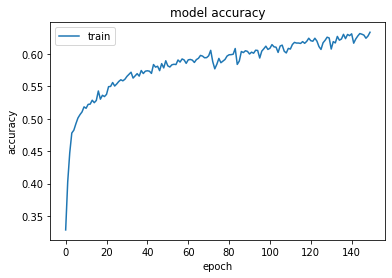

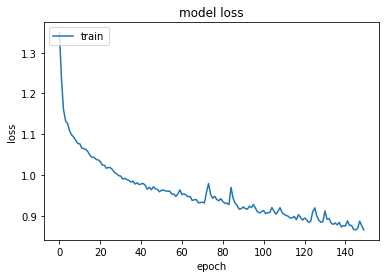

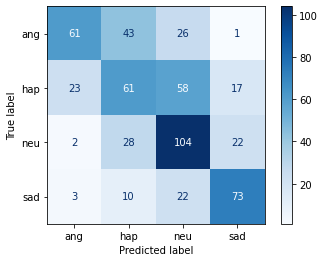

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 53.97111773490906 (+- 0.0)
> Loss: 1.1258504390716553
> F1: 53.62721863975052
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
156/156 [==============================] - 8s 41ms/step - loss: 1.3683 - accuracy: 0.2903
Epoch 2/150
156/156 [==============================] - 6s 40ms/step - loss: 1.2986 - accuracy: 0.3795
Epoch 3/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1938 - accuracy: 0.4349
Epoch 4/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1

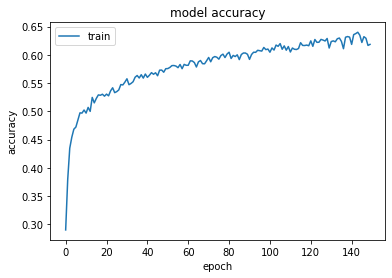

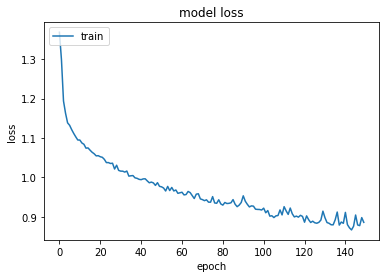

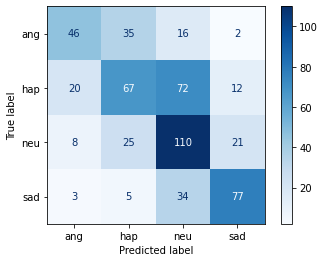

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 54.1103333234787 (+- 0.1392155885696411)
> Loss: 1.105332374572754
> F1: 53.74111445736912
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
156/156 [==============================] - 7s 40ms/step - loss: 1.3230 - accuracy: 0.3391
Epoch 2/150
156/156 [==============================] - 6s 40ms/step - loss: 1.2041 - accuracy: 0.4215
Epoc

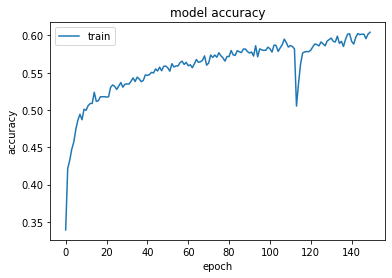

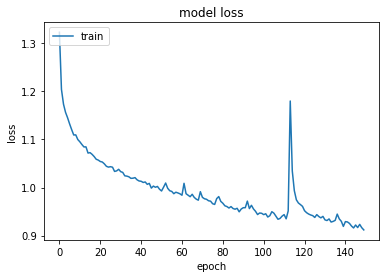

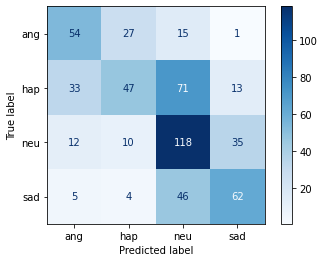

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 53.01146904627482 (+- 1.5581803659493754)
> Loss: 1.1238110860188801
> F1: 52.349534755502354
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/150
156/156 [==================

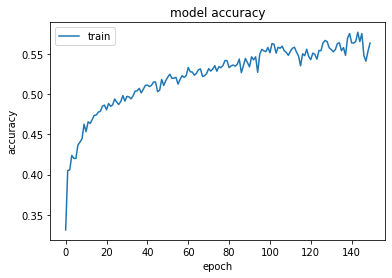

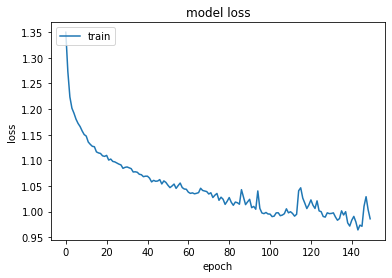

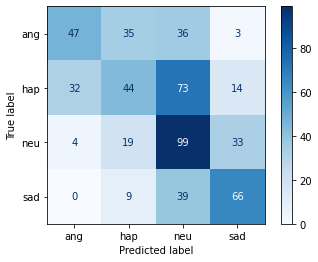

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 51.331838965415955 (+- 3.206932516471228)
> Loss: 1.1449086964130402
> F1: 50.59353435891074
------------------------------------------------

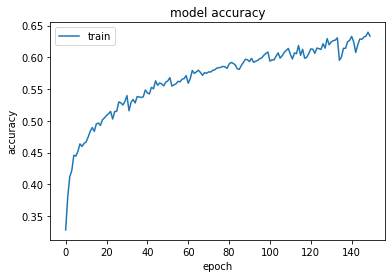

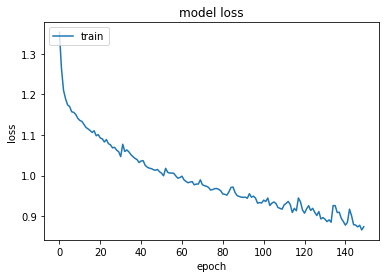

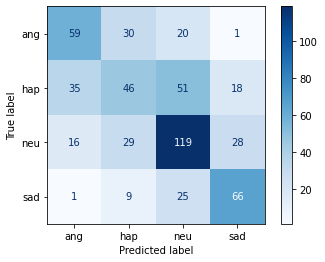

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
Average scores for

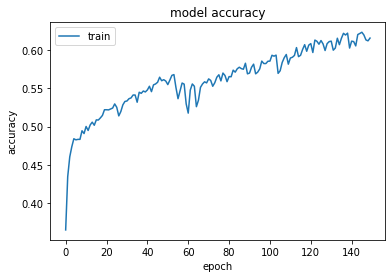

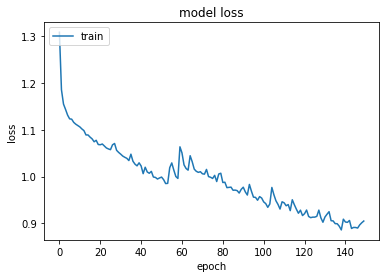

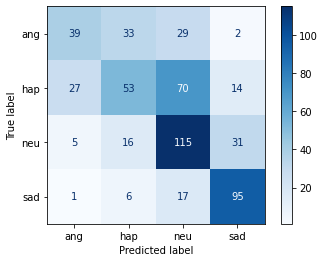

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
> Fold 6 - Loss: 1

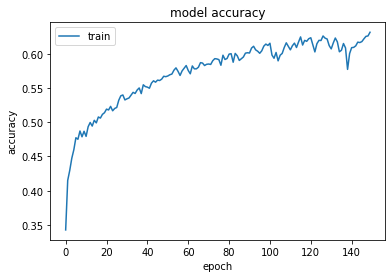

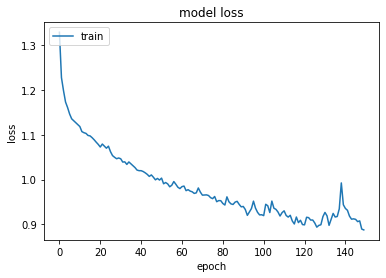

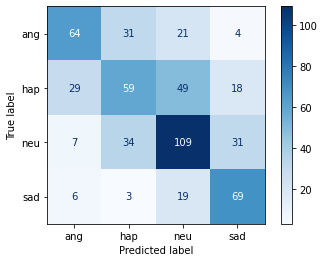

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
> Fold 6 - Loss: 1

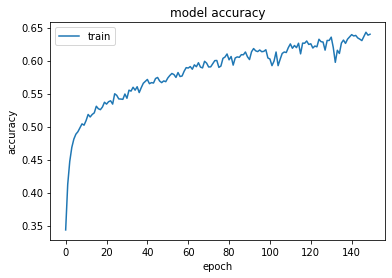

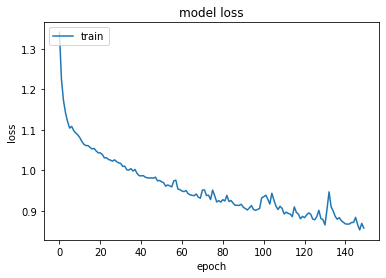

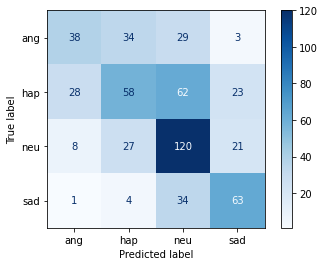

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
> Fold 6 - Loss: 1

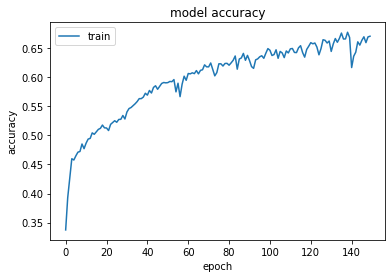

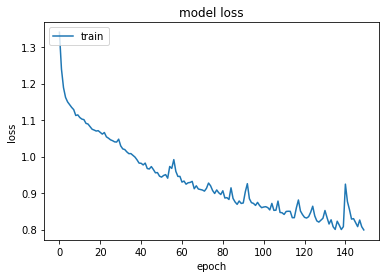

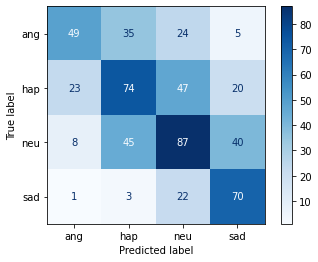

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
> Fold 6 - Loss: 1

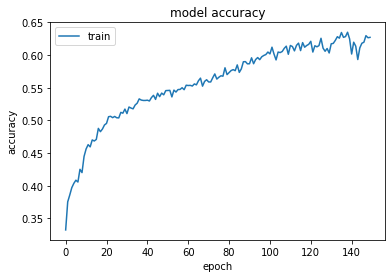

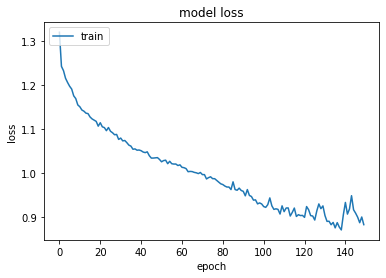

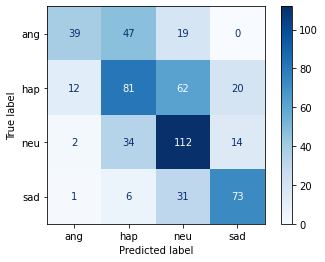

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.1258504390716553 - Accuracy: 53.97111773490906% - F1: 53.62721863975052
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0848143100738525 - Accuracy: 54.24954891204834% - F1: 53.85501027498773
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1607685089111328 - Accuracy: 50.813740491867065% - F1: 49.566375351768805
------------------------------------------------------------------------
> Fold 4 - Loss: 1.20820152759552 - Accuracy: 46.292948722839355% - F1: 45.3255331691359
------------------------------------------------------------------------
> Fold 5 - Loss: 1.2232314348220825 - Accuracy: 52.441227436065674% - F1: 51.64195454659682
------------------------------------------------------------------------
> Fold 6 - Loss: 1

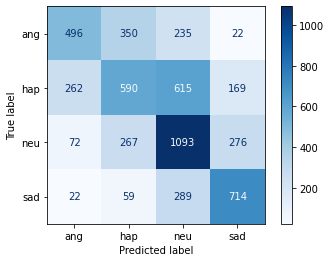

In [ ]:
k_fold_fit_re('LSTM', X, yy, folds=10, numepoch = 150, batchsize = 32)

#Stratified k-fold cross-validation
##k = 10


paragraph explaining the need of such cross val


In [ ]:
def strat_k_fold_fit_re(model_type,X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import f1_score
  le = LabelEncoder()
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the stratified K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=folds, shuffle=True)
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):
    #label encoding comes after the split
    yy = to_categorical(le.fit_transform(y))
    if (model_type =='LSTM'):
      model = LSTM()
    else:
      return
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model and save details to history
    history = model.fit(X[train], yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #conf matrix ctnd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/150
156/156 [==============================] - 8s 40ms/step - loss: 1.3434 - accuracy: 0.3357
Epoch 2/150
156/156 [==============================] - 6s 40ms/step - loss: 1.2263 - accuracy: 0.4105
Epoch 3/150
156/156 [==============================] - 6s 39ms/step - loss: 1.1711 - accuracy: 0.4404
Epoch 4/150
156/156 [==============================] - 6s 41ms/step - loss: 1.1609 - accuracy: 0.4549
Epoch 5/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1486 - accuracy: 0.4563
Epoch 6/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1404 - accuracy: 0.4647
Epoch 7/150
156/156 [==============================] - 6s 40ms/step - loss: 1.1323 - accuracy: 0.4750
Epoch 8/150
156/156 [==============================] - 6s 39ms/step - loss: 1.1254 - accuracy: 0.4810
Epoch 9/150
156/156 [==============================] - 6s 39ms/step - loss: 1.1185 - ac

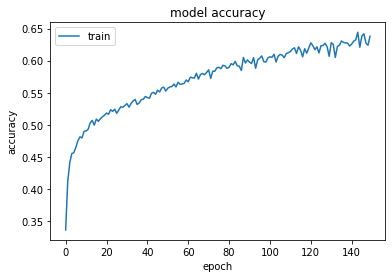

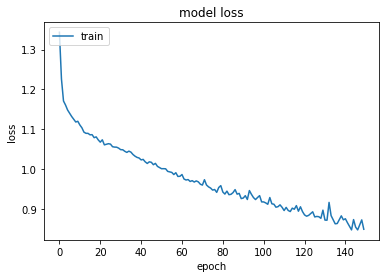

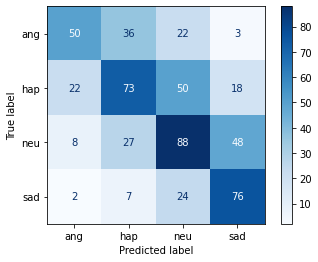

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 51.805055141448975 (+- 0.0)
> Loss: 1.2764533758163452
> F1: 51.49639105475927
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/150
156/156 [==============================] - 7s 39ms/step - loss: 1.3271 - accuracy: 0.3495
Epoch 2/150
156/156 [==============================] - 6s 39ms/step - loss: 1.2227 - accuracy: 0.4036
Epoch 3/150
156/156 [==============================] - 6s 39ms/step - loss: 1.1625 - accuracy: 0.4397
Epoch 4/150
156/156 [==============================] - 6s 39ms/step - loss: 

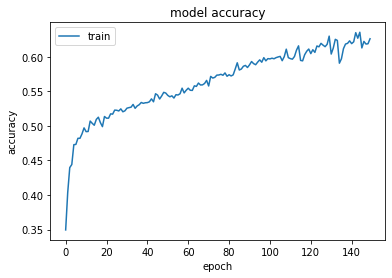

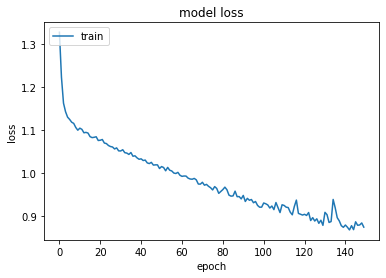

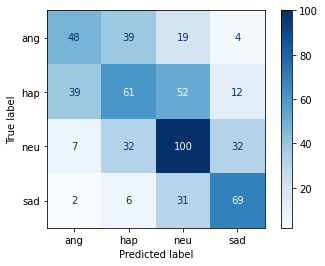

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 51.03815197944641 (+- 0.7669031620025635)
> Loss: 1.249833345413208
> F1: 50.65260778726794
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/150
156/156 [==============================] - 7s 40ms/step - loss: 1.3103 - accuracy: 0.3507
Epoch 2/150
156/156 [==============================] - 6s 39ms/step - loss: 1.2149 - accuracy: 0.4130
E

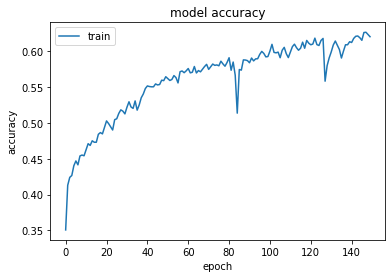

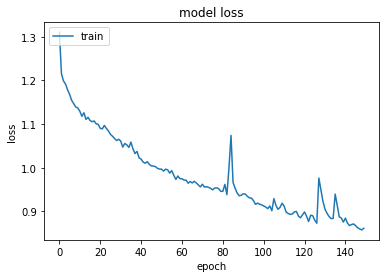

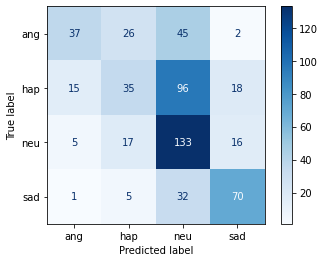

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 50.60168504714966 (+- 0.8792612842059122)
> Loss: 1.2342065970102947
> F1: 49.49732682619656
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/150
156/156 [==================

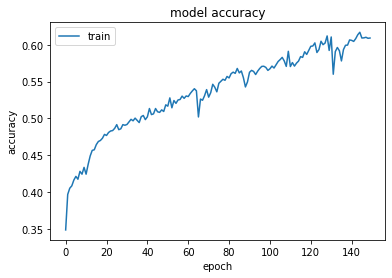

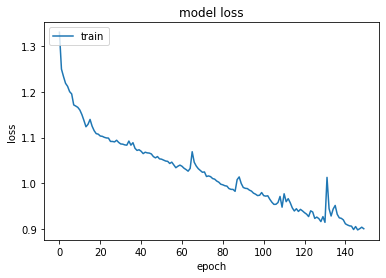

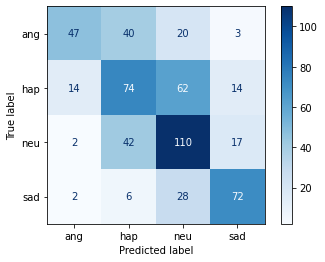

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 51.64927393198013 (+- 1.9677786255797796)
> Loss: 1.1838080883026123
> F1: 50.79512138418757
--------------------------------------------

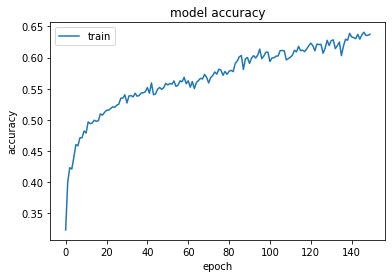

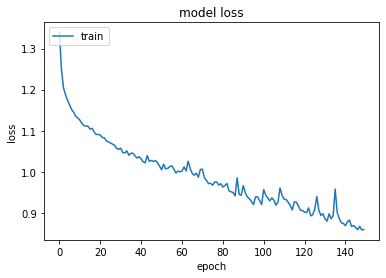

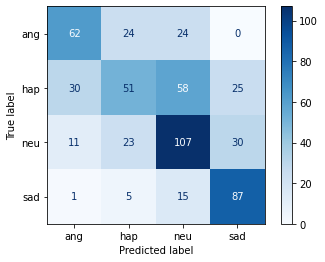

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
Average score

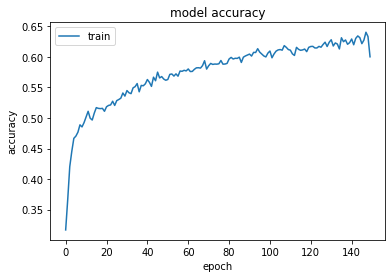

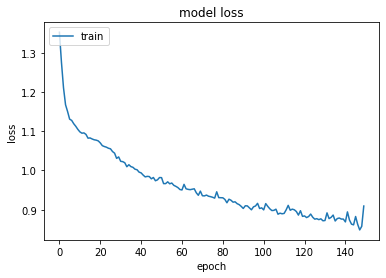

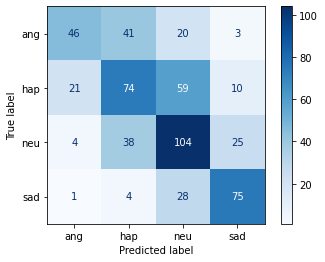

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
> Fold 6 - Lo

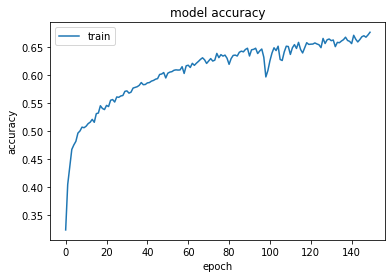

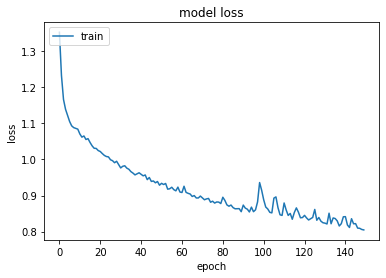

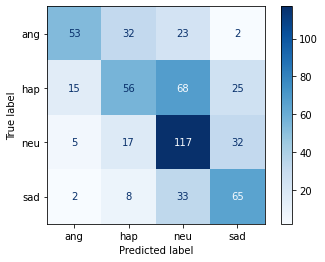

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
> Fold 6 - Lo

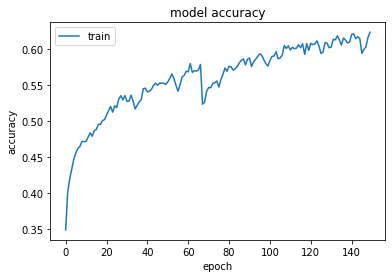

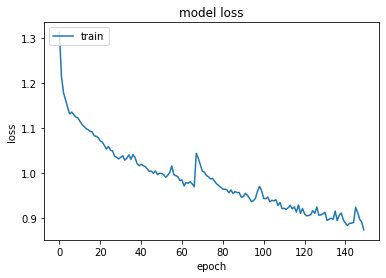

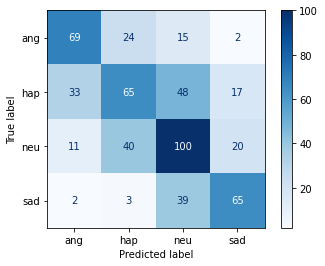

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
> Fold 6 - Lo

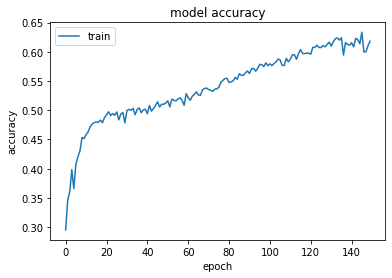

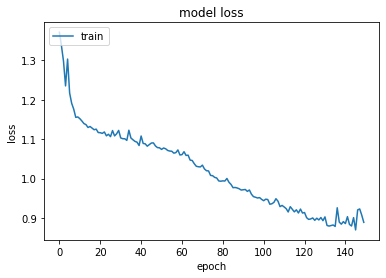

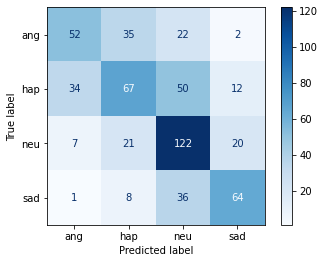

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
> Fold 6 - Lo

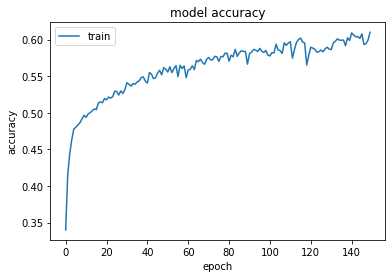

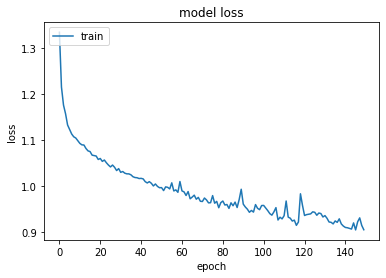

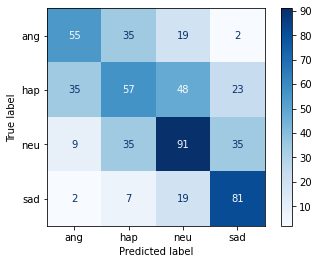

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.2764533758163452 - Accuracy: 51.805055141448975% - F1: 51.49639105475927%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.2232133150100708 - Accuracy: 50.27124881744385% - F1: 49.8088245197766%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.2029531002044678 - Accuracy: 49.72875118255615% - F1: 47.18676490405381%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0326125621795654 - Accuracy: 54.79204058647156% - F1: 54.68850505816059%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1411080360412598 - Accuracy: 55.51537275314331% - F1: 54.094394783050234%
------------------------------------------------------------------------
> Fold 6 - Lo

In [ ]:
strat_k_fold_fit_re('LSTM', X, yy, folds=10, numepoch = 150, batchsize = 32)

#Train the model over the whole dataset and save the model

In [ ]:
X.shape

(5531, 517, 40)

In [ ]:
yy.shape

(5531, 4)

In [ ]:
model = LSTM()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
history = model.fit(X, yy,
                batch_size=32,
                epochs=150,
                verbose=1)
# model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/lstm_model') 
# keras.models.load_model('path/to/location')

Epoch 1/150
173/173 [==============================] - 9s 41ms/step - loss: 1.3697
Epoch 2/150
173/173 [==============================] - 7s 39ms/step - loss: 1.3296
Epoch 3/150
173/173 [==============================] - 7s 39ms/step - loss: 1.2468
Epoch 4/150
173/173 [==============================] - 7s 39ms/step - loss: 1.2202
Epoch 5/150
173/173 [==============================] - 7s 39ms/step - loss: 1.2009
Epoch 6/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1689
Epoch 7/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1509
Epoch 8/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1318
Epoch 9/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1216
Epoch 10/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1117
Epoch 11/150
173/173 [==============================] - 7s 39ms/step - loss: 1.1016
Epoch 12/150
173/173 [==============================] - 7s 39ms/step - loss: 1.0961
E

AttributeError: ignored

The solution is to specify the h5 format

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/lstm_model.h5') 

In [ ]:
#double check
import tensorflow as tf
from tensorflow import keras
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/lstm_model.h5')

# Check its architecture
new_model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cu_dnnlstm_40 (CuDNNLSTM)   (None, 517, 64)           27136     
                                                                 
 cu_dnnlstm_41 (CuDNNLSTM)   (None, 64)                33280     
                                                                 
 dense_40 (Dense)            (None, 64)                4160      
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_41 (Dense)            (None, 4)                 260       
                                                                 
Total params: 64,836
Trainable params: 64,836
Non-trainable params: 0
_________________________________________________________________


#Application of saved model

The result is obviously not satisfying as the trained model overfitted a lot. It strugles to classify emotions from the dataset itself not to say the real audio which is not segmented. Also the method of acquiring audio from google colab has its limitations. It only records sound with sampling rate of 48000. In this sense the audio is resampled to 20500 so it matches the sr of the audio used for training.


In [13]:
!pip install ffmpeg-python

In [14]:
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [15]:
audio, sr = get_audio()

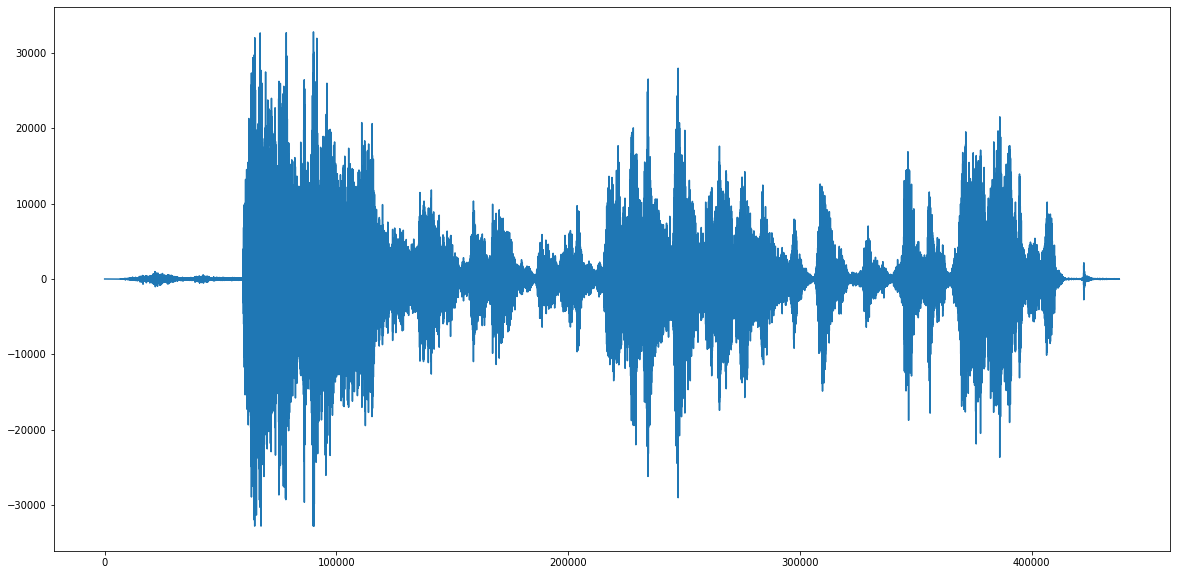

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(audio)
plt.show()

In [ ]:
audio.shape[0]

126720

##Trim and fill procedure so recorded audio meets the input shape requirments

Although, it can be achieved with pydub library, I found it more useful to directly pad the array with zeros whenever the audio is too short and trim the array of audio data when its too big

In [16]:
samples_orig = audio.shape[0]/48000
if(samples_orig > 12):
  audio = audio[:12*48000]
else:
  N_pad = 12*48000-audio.shape[0]
  print(N_pad/48000)
  audio = np.hstack((audio,np.zeros(N_pad)))
print(audio.shape[0]/48000)

9.42
12.0


##Resampling the audio and extracting 40 MFCCs

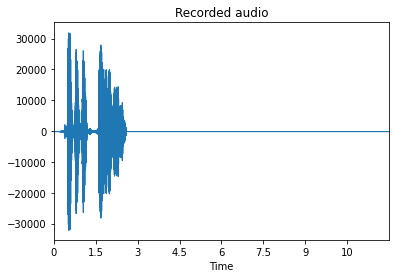

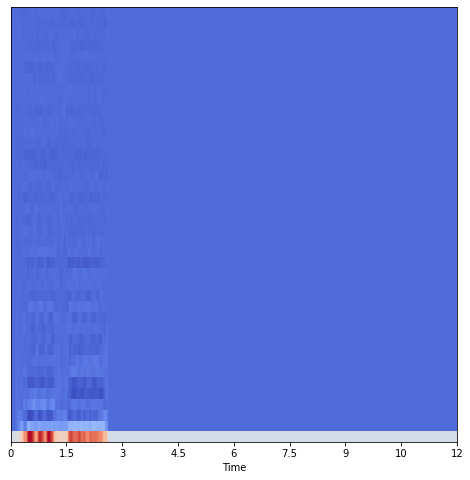

In [17]:
arr = np.array(audio).astype(np.float32)
arr = librosa.resample(arr, orig_sr=48000, target_sr=22050)
import librosa.display
plt.title('Recorded audio')
librosa.display.waveplot(arr, sr= 22050)
mfccs = librosa.feature.mfcc(y=arr, sr=22050, n_mfcc = 40)
plt.figure(figsize=(8,8))
librosa.display.specshow(mfccs, sr=22050, x_axis='time')

In [ ]:
mfccs.shape

(40, 517)

Since now its about to be fed to rnn-lstm model, the mfcc is transposed

In [18]:
mfccsT = mfccs.T
mfccsT.shape

(517, 40)

In [19]:
temparr =  saved_model.predict(mfccsT.reshape(1,517,40))
print(temparr)
np.argmax(temparr)

[[0.10826232 0.2323169  0.27546173 0.38395908]]


3

0->angry
1->happy
2->neutral
3->sad


Model is faulty in terms of classification, it strugles to diffentiate emotions and most of the time it gives sadness label to audio

#Model training with early stopping


Epoch 1/150
139/139 [==============================] - ETA: 0s - loss: 1.3530 - accuracy: 0.3214
Epoch 1: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_lstm.h5
139/139 [==============================] - 8s 50ms/step - loss: 1.3530 - accuracy: 0.3214 - val_loss: 1.3235 - val_accuracy: 0.3640
Epoch 2/150
139/139 [==============================] - ETA: 0s - loss: 1.2741 - accuracy: 0.3786
Epoch 2: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_lstm.h5
139/139 [==============================] - 6s 44ms/step - loss: 1.2741 - accuracy: 0.3786 - val_loss: 1.2330 - val_accuracy: 0.4128
Epoch 3/150
139/139 [==============================] - ETA: 0s - loss: 1.2121 - accuracy: 0.4046
Epoch 3: saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_lstm.h5
139/139 [==============================] - 6s 44ms/step - loss: 1.2121 - accuracy: 0.4046 - val_loss: 1.20

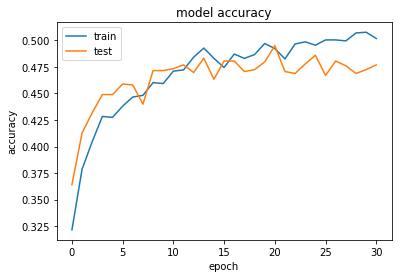

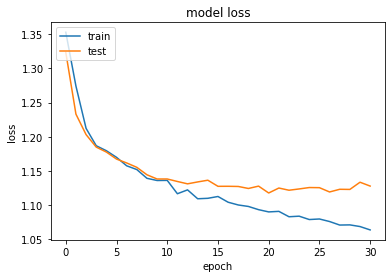

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
n_splits = 1  # We only want a single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=0)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_lstm.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=False)
for train_index, test_index in sss.split(X, y):
    yy = to_categorical(le.fit_transform(y))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    model = LSTM()
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=150, verbose=1, callbacks=[es, mc])
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_lstm.h5')
